In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from basic_tools import *

debug=False

# Load variables

## Load phenotype information of individuals

In [2]:
phenotype_raw_AS=pd.read_csv(phenotype_raw_AS_path,sep='\t',index_col='ID')
phenotype_raw_AS['cohort']=1
phenotype_raw_CT=pd.read_csv(phenotype_raw_CT_path,sep='\t',index_col='ID')
phenotype_raw_CT['cohort']=2
phenotype_raw_NC=pd.read_csv(phenotype_raw_NC_path,sep='\t',index_col='ID')
phenotype_raw_NC.columns=phenotype_raw_NC.columns.str.replace('NCB','NC1')
phenotype_raw_NC['cohort']=3

phenotype_raw_AS.shape,phenotype_raw_CT.shape,phenotype_raw_NC.shape

/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (9,11,158,552,1301) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (391,516) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (87,97,101,105,208,270,373,382,388) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


((7612, 1316), (99234, 578), (19004, 431))

In [3]:
phenotype_raw=pd.concat([phenotype_raw_AS,phenotype_raw_CT,phenotype_raw_NC])
phenotype_raw=phenotype_raw.sort_values('ID')
phenotype_raw.shape

/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(125850, 2323)

In [4]:
#phenotype_raw=phenotype_raw.loc[['BHAN{:06d}'.format(i) for i in range(1,125872+1)]]

#assert sum(phenotype_raw.index.duplicated())==0
#len(phenotype_raw.index)
#phenotype_raw['CT1_GLU16_U']

## Load codebook

In [5]:
codebook_AS=pd.read_csv(codebook_AS_path)#,header=1)
codebook_CT=pd.read_csv(codebook_CT_path)#,header=1)
codebook_NC=pd.read_csv(codebook_NC_path)

codebook_column_dict={"테이블명(영문)":"table_code","변수명": "phenotype_code","변수설명":"description", "변수값(코드) 설명": "value_description","변수유형":"type","설문지":"questionnaire"}
codebook_AS=codebook_AS.rename(columns=codebook_column_dict)
codebook_CT=codebook_CT.rename(columns=codebook_column_dict)
codebook_NC=codebook_NC.rename(columns=codebook_column_dict)

codebook_AS['type']=codebook_AS['type'].replace('범주형','categorical').replace('연속형','continuous').replace('서술형','descriptive').replace('날짜','date')
codebook_CT['type']=codebook_CT['type'].replace('범주형','categorical').replace('연속형','continuous').replace('서술형','descriptive').replace('날짜','date')
codebook_NC['type']=codebook_NC['type'].replace('범주형','categorical').replace('연속형','continuous').replace('서술형','descriptive').replace('날짜','date')

codebook_AS['phenotype_code']=codebook_AS['phenotype_code'].str.upper()

codebook_total=pd.concat([codebook_AS,codebook_CT,codebook_NC])

/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


# Run conversion manual

## syntax analyzer

In [6]:
def run_command(series_in,match_value,expression):
    series_out=series_in.copy()
    series_out[series_out.index]=np.nan
    if 'x' in match_value:
        #expression='(x>10)&(x!=77777)&(x!=99999)'
        #Only float variable is supported
        def match_value_function(x):
            try:
                return False if pd.isnull(x) else eval(match_value.replace('x',str(x))) 
            except:
                print(x,end='Error')
                return False
        match_bool=series_in.map(match_value_function)
        expression_function=lambda x:eval(expression.replace('x',str(x)))
        series_out[match_bool]=series_in[match_bool].map(expression_function)
    else:
        #print(np.sum(series_in==float(match_value)))
        try:
            match_value=float(match_value)
        except:
            pass
        try:
            expression=float(expression)
        except:
            pass
        #print(series_in.unique(),(series_in=='폐암').sum(),'폐암',match_value,match_value.strip("'")=='폐암',type('폐암'),type(match_value),match_value,expression)
        if type(match_value)==str and '+' in match_value:
            print("!! contain mode !!")
            series_out[series_in.map(lambda x: False if pd.isnull(x) or type(x)!=str else (match_value.replace('+','') in x))]=expression
        else:
            series_out[series_in==match_value]=expression
    return series_out

#conversion_manual.to_csv(conversion_manual_path,sep='\t',index=None)

## Run specific conversion (for debugging)

### Check if need

In [7]:
"""
(phenotype_raw['AS1_TRTAS']==2).sum(),(phenotype_raw['AS1_PDAS']==2).sum()
phenotype_raw.index[(phenotype_raw['CT1_ASTHCU']>=1) & (phenotype_raw['CT1_ASTHCU']<=4)].difference(phenotype_raw.index[phenotype_raw['CT1_ASTH']==2])
a=phenotype_raw.index[phenotype_raw['AS1_TRTAS']==2].difference(phenotype_raw.index[phenotype_raw['AS1_PDAS']==1])
len(a)

phenotype_raw['NC1_CA1'].unique(),phenotype_raw['NC1_CA_NA2'].unique()

phenotype_raw['AS1_HIP1'].hist()

(phenotype_raw['AS1_HIP1']-phenotype_raw['AS1_HIP2']).hist()

phenotype_raw_CT.columns[phenotype_raw_CT.columns.str.contains('BLOOD')]
(phenotype_raw['NC1_CRP'][phenotype_raw['NC1_CRP']!=99999]*0.1).median()
(phenotype_raw['AS1_PDDEM']).value_counts()
#(phenotype_raw['AS1_PREGNO']-phenotype_raw['AS1_CHILD_P']-phenotype_raw['AS1_CHILD_D']).value_counts()
"""

"\n(phenotype_raw['AS1_TRTAS']==2).sum(),(phenotype_raw['AS1_PDAS']==2).sum()\nphenotype_raw.index[(phenotype_raw['CT1_ASTHCU']>=1) & (phenotype_raw['CT1_ASTHCU']<=4)].difference(phenotype_raw.index[phenotype_raw['CT1_ASTH']==2])\na=phenotype_raw.index[phenotype_raw['AS1_TRTAS']==2].difference(phenotype_raw.index[phenotype_raw['AS1_PDAS']==1])\nlen(a)\n\nphenotype_raw['NC1_CA1'].unique(),phenotype_raw['NC1_CA_NA2'].unique()\n\nphenotype_raw['AS1_HIP1'].hist()\n\n(phenotype_raw['AS1_HIP1']-phenotype_raw['AS1_HIP2']).hist()\n\nphenotype_raw_CT.columns[phenotype_raw_CT.columns.str.contains('BLOOD')]\n(phenotype_raw['NC1_CRP'][phenotype_raw['NC1_CRP']!=99999]*0.1).median()\n(phenotype_raw['AS1_PDDEM']).value_counts()\n#(phenotype_raw['AS1_PREGNO']-phenotype_raw['AS1_CHILD_P']-phenotype_raw['AS1_CHILD_D']).value_counts()\n"

In [16]:
name_filter='glucose_in_urine'
test_match_value=1
test_conversion_value=2

conversion_manual=pd.read_csv(conversion_manual_path,sep='\t',index_col='phenotype_code')

##Run all 'commands' with name=='new_name'
conversion_list_dict={}
for idx,row in conversion_manual[~pd.isnull(conversion_manual['commands'])].iterrows():
    for command in row['commands'].split('|'):
        new_name,match_value,expression=command.split('@')
        if name_filter!=None and new_name!=name_filter:
            continue
        print(idx,command,phenotype_raw[idx].unique())
        print("# of filtered={} before: ".format(test_match_value),(phenotype_raw[idx]==test_match_value).sum())
        conversion=run_command(phenotype_raw[idx],match_value,expression)
        conversion_list_dict[new_name]=conversion_list_dict.get(new_name,[])+[conversion]
        print("# of filtered={} after: ".format(test_conversion_value),(conversion==test_conversion_value).sum(),", conversion unique",conversion.unique())
        print('-----------------------------------------')

NC1_GLU16_U glucose_in_urine@(x>1)&(x<6)@2 [0.0000e+00 4.0000e+00 1.0000e+00 5.0000e+00 2.0000e+00 3.0000e+00
 9.9999e+04        nan]
# of filtered=1 before:  1316
# of filtered=2 after:  698 , conversion unique [nan  2.]
-----------------------------------------
AS1_GLU16_U glucose_in_urine@(x>0)&(x<5)@2 [        nan -1.0000e+00  4.0000e+00  0.0000e+00  1.0000e+00  2.0000e+00
  3.0000e+00  9.9999e+04]
# of filtered=1 before:  102
# of filtered=2 after:  606 , conversion unique [nan  2.]
-----------------------------------------


In [17]:
print("--------------Conversion----------------------")
# merge results of same 'new_name'
conversion_dict={}
for new_name,conversion_list in conversion_list_dict.items():
    merge_result=None
    for conversion_result in conversion_list:
        if merge_result is None:
            merge_result= conversion_result
        else:
            merge_result.update(conversion_result)
    print(new_name,str(merge_result.unique())[:30])
    conversion_dict[new_name]=merge_result
#cohort 별 분포
print('# of null:', conversion_dict[name_filter].isnull().sum())
conversion_dict[name_filter].value_counts()

--------------Conversion----------------------
glucose_in_urine [nan  2.]
# of null: 124546


2.0    1304
Name: NC1_GLU16_U, dtype: int64

In [18]:
print('# of {} in AS:'.format(test_conversion_value),\
      (phenotype_raw[conversion_dict[name_filter]==test_conversion_value]['cohort']==1).sum(),'/',\
      (phenotype_raw['cohort']==1).sum(),\
      '{:.2f}'.format((phenotype_raw[conversion_dict[name_filter]==test_conversion_value]['cohort']==1).sum()/(phenotype_raw['cohort']==1).sum()*100),\
     )
print('# of {} in CT:'.format(test_conversion_value),\
      (phenotype_raw[conversion_dict[name_filter]==test_conversion_value]['cohort']==2).sum(),'/',\
      (phenotype_raw['cohort']==2).sum(),\
      '{:.2f}'.format((phenotype_raw[conversion_dict[name_filter]==test_conversion_value]['cohort']==2).sum()/(phenotype_raw['cohort']==2).sum()*100),\
     )

print('# of {} in NC:'.format(test_conversion_value),\
      (phenotype_raw[conversion_dict[name_filter]==test_conversion_value]['cohort']==3).sum(),'/',\
      (phenotype_raw['cohort']==3).sum(),\
      '{:.2f}'.format((phenotype_raw[conversion_dict[name_filter]==test_conversion_value]['cohort']==3).sum()/(phenotype_raw['cohort']==3).sum()*100),\
     )

      #'---','{:.2f}'.format(phenotype_raw['AS1_contain'][conversion_dict[name_filter]==test_conversion_value].sum()/phenotype_raw['AS1_contain'].sum()*100))

# of 2 in AS: 606 / 7612 7.96
# of 2 in CT: 0 / 99234 0.00
# of 2 in NC: 698 / 19004 3.67


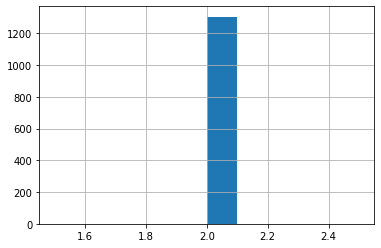

In [19]:
conversion_dict[name_filter].hist()
plt.show()

## Run all conversion (for debugging)

In [20]:
conversion_manual=pd.read_csv(conversion_manual_path,sep='\t',index_col='phenotype_code')

In [21]:
#conversion_list_dict.keys()

In [22]:
name_filter=None
test_match_value=1
test_conversion_value=2

##Run all 'commands' with name=='new_name'
conversion_list_dict={}
for idx,row in conversion_manual[~pd.isnull(conversion_manual['commands'])].iterrows():
    for command in row['commands'].split('|'):
        new_name,match_value,expression=command.split('@')
        if name_filter!=None and new_name!=name_filter:
            continue
        print(idx,command,phenotype_raw[idx].unique())
        print("# of filtered={} before: ".format(test_match_value),(phenotype_raw[idx]==test_match_value).sum())
        conversion=run_command(phenotype_raw[idx],match_value,expression)
        conversion_list_dict[new_name]=conversion_list_dict.get(new_name,[])+[conversion]
        print("# of filtered={} after: ".format(test_conversion_value),(conversion==test_conversion_value).sum(),", conversion unique",conversion.unique())
        print('-----------------------------------------')

NC1_AGE age@(x!=66666)&(x!=77777)&(x!=99999)@x [67. 60. 51. 70. 68. 77. 65. 50. 56. 74. 62. 72. 69. 49. 57. 59. 53. 52.
 55. 73. 78. 71. 45. 61. 75. 63. 46. 54. 80. 66. 64. 47. 44. 58. 48. 76.
 79. 41. 86. 87. 40. 81. 43. 82. 42. 85. 84. 90. 83. 88. nan]
# of filtered=1 before:  0
# of filtered=2 after:  0 , conversion unique [67. 60. 51. 70. 68. 77. 65. 50. 56. 74. 62. 72. 69. 49. 57. 59. 53. 52.
 55. 73. 78. 71. 45. 61. 75. 63. 46. 54. 80. 66. 64. 47. 44. 58. 48. 76.
 79. 41. 86. 87. 40. 81. 43. 82. 42. 85. 84. 90. 83. 88. nan]
-----------------------------------------
CT1_AGE age@(x!=66666)&(x!=77777)&(x!=99999)@x [nan 63. 45. 59. 50. 51. 61. 55. 48. 53. 60. 70. 57. 66. 44. 46. 56. 58.
 52. 41. 67. 47. 40. 42. 49. 43. 54. 62. 65. 69. 64. 68. 71. 72. 73. 76.
 75. 74. 77. 79. 78.]
# of filtered=1 before:  0
# of filtered=2 after:  0 , conversion unique [nan 63. 45. 59. 50. 51. 61. 55. 48. 53. 60. 70. 57. 66. 44. 46. 56. 58.
 52. 41. 67. 47. 40. 42. 49. 43. 54. 62. 65. 69. 64. 68. 71. 

In [23]:
print("--------------Conversion----------------------")
# merge results of same 'new_name'
conversion_dict={}
for new_name,conversion_list in conversion_list_dict.items():
    merge_result=None
    for conversion_result in conversion_list:
        if merge_result is None:
            merge_result= conversion_result
        else:
            merge_result.update(conversion_result)
    print(new_name,str(merge_result.unique())[:30])
    conversion_dict[new_name]=merge_result
#cohort 별 분포

--------------Conversion----------------------
age [67. 60. 51. 70. 68. 77. 65. 5
sex [2. 1.]
asthma [nan  2.]
chronic_bronchitis [nan  2.]
allergic_disease [nan  2.]
stomach_cancer [nan 2.0]
liver_cancer [nan 2.0]
colorectal_cancer [nan 2.0]
breast_cancer [nan 2.0]
cervical_cancer [nan 2.0]
lung_cancer [nan 2.0]
thyroid_cancer [nan 2.0]
prostate_cancer [nan 2.0]
bladder_cancer [nan 2.0]
colon_polyps [nan  2.]
angina_pectoris_myocardial_infarction [nan  2.]
hypertension [nan  2.]
stroke [nan  2.]
transient_ischemic_attacks [nan  2.]
acute_liver_disease [nan  2.]
diabetes [ 2. nan]
hyperlipidemia [nan  2.]
thyroid_disease [nan  2.]
arthritis [nan  2.]
rheumatoid_arthritis [nan  2.]
osteoporosis [nan  2.]
parkinson [nan  2.]
pwi_total [nan 27.  7. 10. 11. 12. 37.  
chronic_gastritis_stomach_ulcer [nan  2.]
duodenal_ulcer [nan  2.]
urinary_tract_infection [nan  2.]
height [136.7 159.4 162.5 143.3 154. 
hip_circumference [ 92.    94.4   85.6   94.5   
waist_circumference [ 93.    92.7   79

## converting to Pandas DataFrame

In [24]:
conversion_df=pd.DataFrame(conversion_dict)
conversion_df['cohort']=phenotype_raw['cohort']
conversion_df['bmi']=(conversion_df['weight']/((0.01*conversion_df['height'])**2)).round(2)

## (optional) human-readable transformation manual

In [25]:
conversion_manual_nonull=conversion_manual[~pd.isnull(conversion_manual['commands'])]
conversion_manual_nonull['new_name']=conversion_manual_nonull['commands'].map(lambda x: x.split('|')[0].split('@')[0])

/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
#conversion_manual_nonull

In [27]:
conversion_manual_codebook=pd.DataFrame(columns=pd.MultiIndex.from_product([[i for i in range(0,15)], list(codebook_column_dict.values())+['commands']], names=['code', 'data']),index=conversion_manual_nonull.new_name.unique())

In [28]:
for new_name in conversion_manual_nonull.new_name.unique():
    conversion_manual_nonull_select=conversion_manual_nonull[conversion_manual_nonull['new_name']==new_name]
    for idx,(phenotype_code,row) in enumerate(conversion_manual_nonull_select.iterrows()):
        codebook_total_select=codebook_total[codebook_total['phenotype_code']==phenotype_code][codebook_column_dict.values()].iloc[0]
        codebook_total_select['commands']=row['commands']
        conversion_manual_codebook.loc[row['new_name']][idx]=codebook_total_select

In [29]:
#conversion_manual_codebook

In [30]:
conversion_manual_codebook.to_csv(conversion_manual_codebook_path,encoding='utf8')

# Clean up

## Saving Phenotype

In [31]:
conversion_df=pd.DataFrame(conversion_dict)
conversion_df['cohort']=phenotype_raw['cohort']
conversion_df['bmi']=(conversion_df['weight']/((0.01*conversion_df['height'])**2)).round(2)

In [32]:
try_float_to_int=lambda x: x if np.isnan(x) else x if x%1!=0 else np.int(x)

#### all

In [33]:
conversion_df_try_int=conversion_df.applymap(try_float_to_int)

In [34]:
conversion_df_try_int.to_csv(pheno_all_file_path,sep='\t')

In [35]:
#conversion_df_try_int['rheumatoid_arthritis']

In [36]:
conversion_df_try_int.shape

(125850, 137)

In [37]:
#conversion_df_try_int[conversion_df_try_int.columns.str.contains('arth')]

#### each

In [48]:
cohort_to_name=lambda x: 'AS' if x==1 else 'CT' if x==2 else 'NC' if x==3 else 'error'

In [42]:
pheno_sumstatsjpg_file_path=data_out_pheno_path+'{}.jpg'

quantitative traits -- age


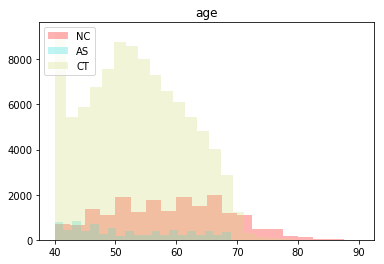

--------------------------------
quantitative traits -- sex


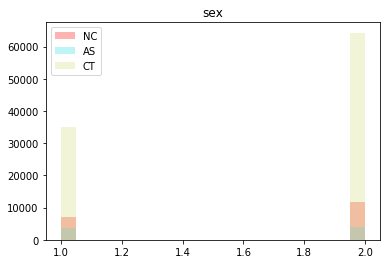

--------------------------------
binary traits -- asthma
    case  control  missing
NC   273    15526     3205
AS   173     5794     1645
CT  1672    79480    18082


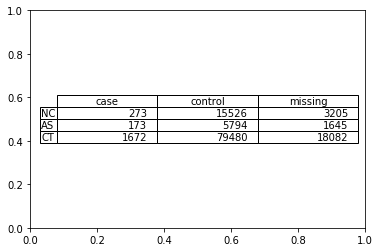

--------------------------------
binary traits -- chronic_bronchitis
     case  control  missing
NC  155.0  15607.0   3242.0
AS    NaN      NaN   7612.0
CT  750.0  80147.0  18337.0


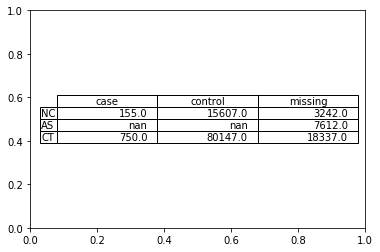

--------------------------------
binary traits -- allergic_disease
    case  control  missing
NC   703    15223     3078
AS  1450     4804     1358
CT  7129    75267    16838


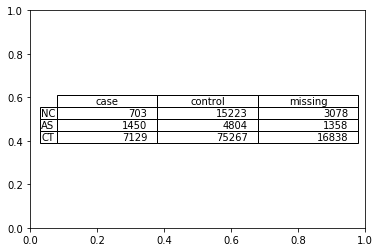

--------------------------------
binary traits -- stomach_cancer
    case  control  missing
NC   135    15600     3269
AS     1     5906     1705
CT   460    80254    18520


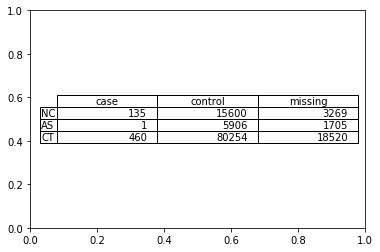

--------------------------------
binary traits -- liver_cancer
    case  control  missing
NC   9.0  15708.0   3287.0
AS   NaN      NaN   7612.0
CT  64.0  80577.0  18593.0


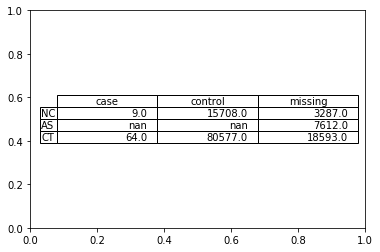

--------------------------------
binary traits -- colorectal_cancer
    case  control  missing
NC    28    15689     3287
AS     1     5905     1706
CT   240    80451    18543


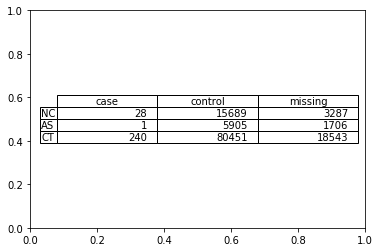

--------------------------------
binary traits -- breast_cancer
    case  control  missing
NC    55    15669     3280
AS    26     5889     1697
CT   552    80211    18471


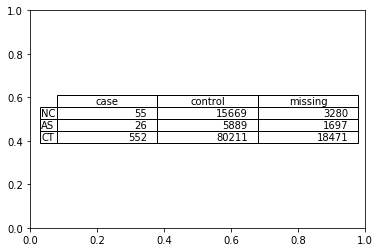

--------------------------------
binary traits -- cervical_cancer
    case  control  missing
NC    28    15714     3262
AS     2     5906     1704
CT   391    80626    18217


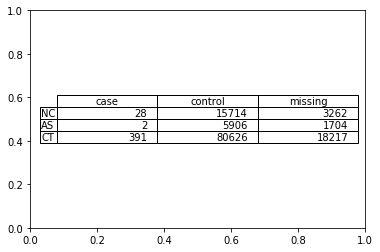

--------------------------------
binary traits -- lung_cancer
    case  control  missing
NC    19    15700     3285
AS     1     5905     1706
CT    71    80575    18588


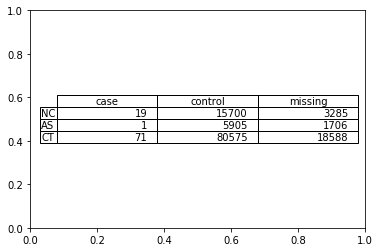

--------------------------------
binary traits -- thyroid_cancer
    case  control  missing
NC    34    15689     3281
AS     1     5906     1705
CT   648    80189    18397


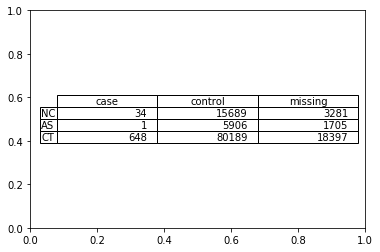

--------------------------------
binary traits -- prostate_cancer
    case  control  missing
NC   5.0  15709.0   3290.0
AS   NaN      NaN   7612.0
CT  53.0  80581.0  18600.0


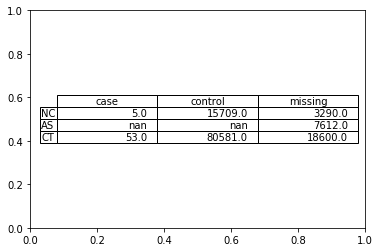

--------------------------------
binary traits -- bladder_cancer
    case  control  missing
NC   5.0  15709.0   3290.0
AS   NaN      NaN   7612.0
CT  42.0  80599.0  18593.0


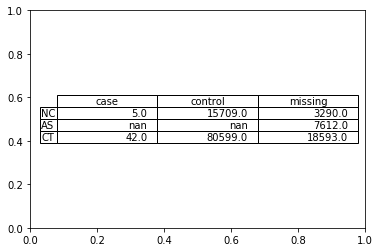

--------------------------------
binary traits -- colon_polyps
      case  control  missing
NC    78.0  15662.0   3264.0
AS     NaN      NaN   7612.0
CT  4129.0  77532.0  17573.0


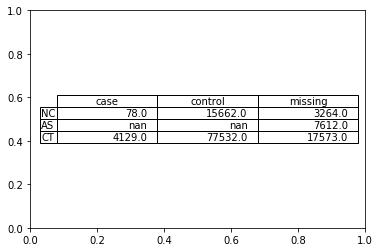

--------------------------------
binary traits -- angina_pectoris_myocardial_infarction
    case  control  missing
NC   477    15368     3159
AS   114     5833     1665
CT  2489    78992    17753


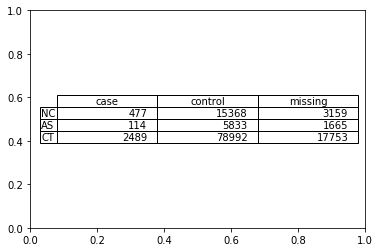

--------------------------------
binary traits -- hypertension
     case  control  missing
NC   5072    11937     1995
AS   1230     5125     1257
CT  19348    67318    12568


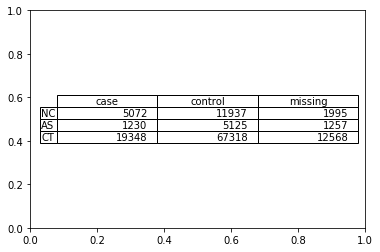

--------------------------------
binary traits -- stroke
    case  control  missing
NC   544    15301     3159
AS    92     5841     1679
CT  1173    79863    18198


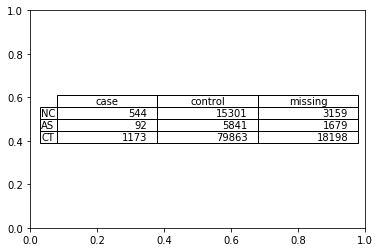

--------------------------------
binary traits -- transient_ischemic_attacks
    case  control  missing
NC  16.0  15704.0   3284.0
AS   NaN      NaN   7612.0
CT  43.0  80605.0  18586.0


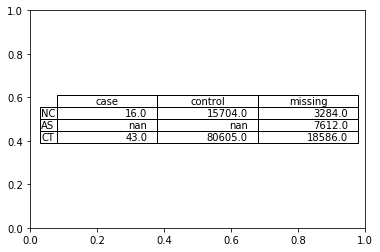

--------------------------------
binary traits -- acute_liver_disease
     case  control  missing
NC   62.0  15677.0   3265.0
AS    NaN      NaN   7612.0
CT  607.0  80183.0  18444.0


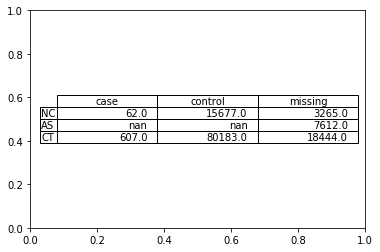

--------------------------------
binary traits -- diabetes
    case  control  missing
NC  1803    15714     1487
AS   534     5906     1172
CT  6575    80626    12033


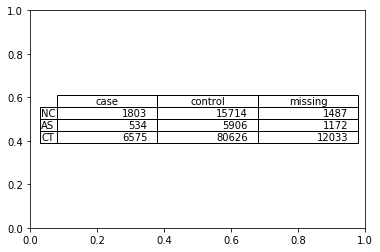

--------------------------------
binary traits -- hyperlipidemia
    case  control  missing
NC  1308    14801     2895
AS   198     5757     1657
CT  9541    74331    15362


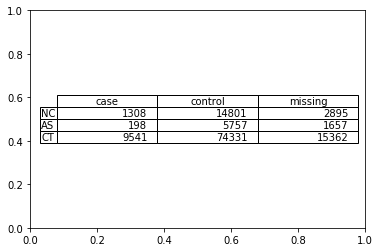

--------------------------------
binary traits -- thyroid_disease
    case  control  missing
NC   321    15714     2969
AS   234     5906     1472
CT  4589    80626    14019


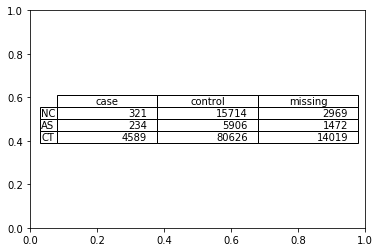

--------------------------------
binary traits -- arthritis
    case  control  missing
NC  1396    15714     1894
AS  1102     5906      604
CT  8860    80626     9748


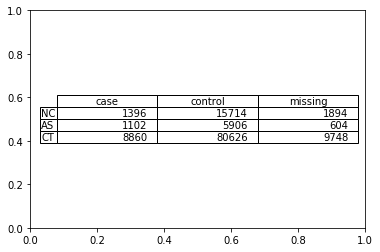

--------------------------------
binary traits -- osteoporosis
    case  control  missing
NC   828    15272     2904
AS   136     5846     1630
CT  5062    77762    16410


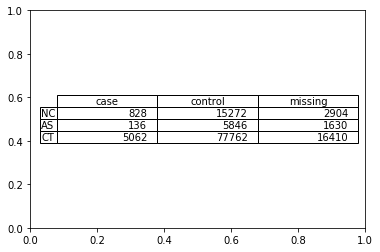

--------------------------------
binary traits -- parkinson
    case  control  missing
NC   6.0  15708.0   3290.0
AS   NaN      NaN   7612.0
CT  26.0  80605.0  18603.0


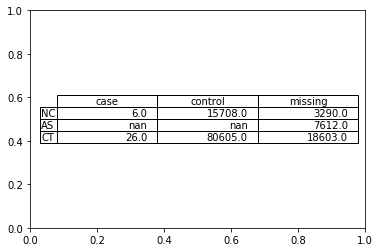

--------------------------------
quantitative traits -- pwi_total


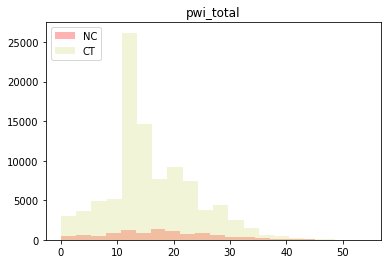

--------------------------------
binary traits -- chronic_gastritis_stomach_ulcer
     case  control  missing
NC   1289    14833     2882
AS   1659     4640     1313
CT  13580    70790    14864


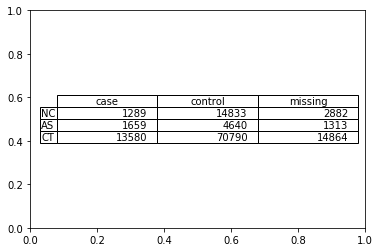

--------------------------------
binary traits -- duodenal_ulcer
      case  control  missing
NC    72.0  15663.0   3269.0
AS     NaN      NaN   7612.0
CT  1614.0  79412.0  18208.0


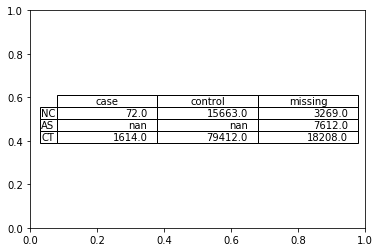

--------------------------------
binary traits -- urinary_tract_infection
    case  control  missing
NC   429    15441     3134
AS    53     5867     1692
CT  1888    79406    17940


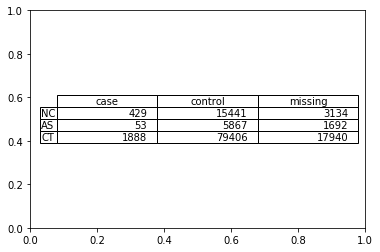

--------------------------------
quantitative traits -- height


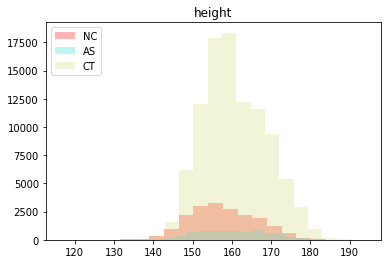

--------------------------------
quantitative traits -- hip_circumference


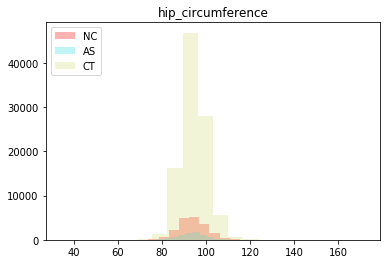

--------------------------------
quantitative traits -- waist_circumference


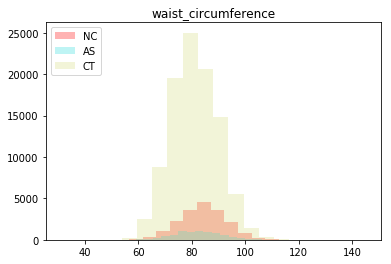

--------------------------------
quantitative traits -- weight


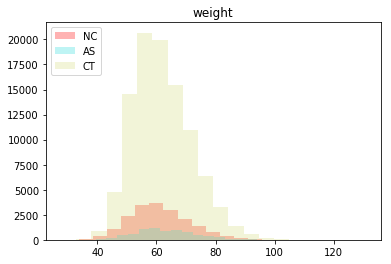

--------------------------------
quantitative traits -- systolic_blood_pressure


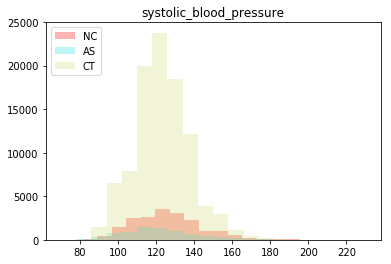

--------------------------------
quantitative traits -- diastolic_blood_pressure


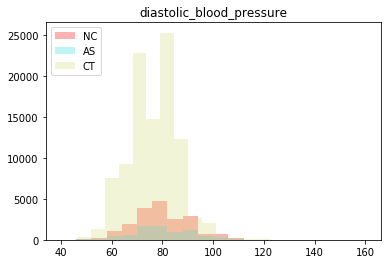

--------------------------------
quantitative traits -- pulse


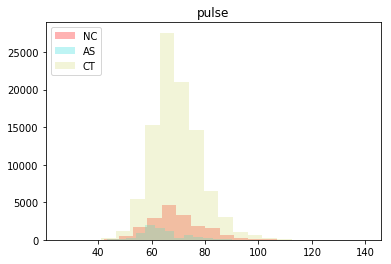

--------------------------------
binary traits -- hysterectomy
      case  control  missing
NC  1241.0  14750.0   3013.0
AS     NaN      NaN   7612.0
CT  7295.0  75503.0  16436.0


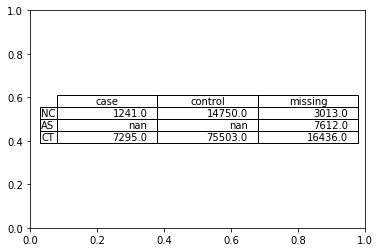

--------------------------------
quantitative traits -- menarche_onset_age


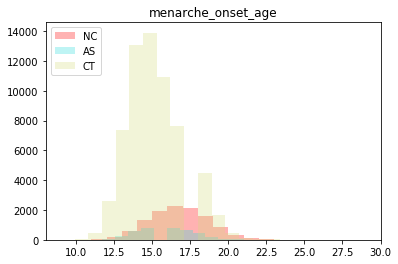

--------------------------------
quantitative traits -- menopause_age


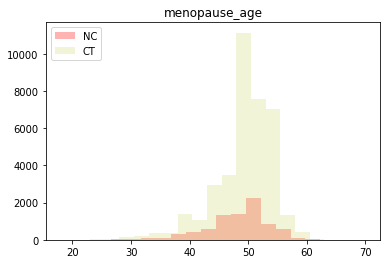

--------------------------------
quantitative traits -- menopause_cycle


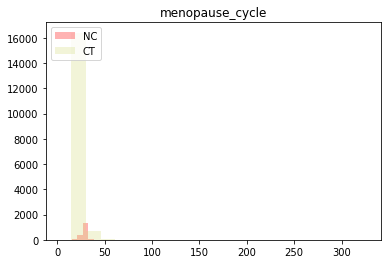

--------------------------------
binary traits -- ovarian_extraction
      case  control  missing
NC    98.0  15626.0   3280.0
AS     NaN      NaN   7612.0
CT  4232.0  77575.0  17427.0


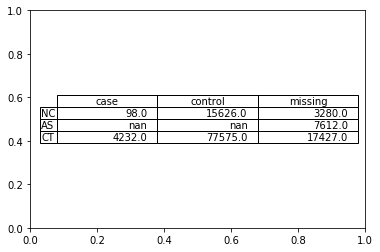

--------------------------------
quantitative traits -- child_delivery_number


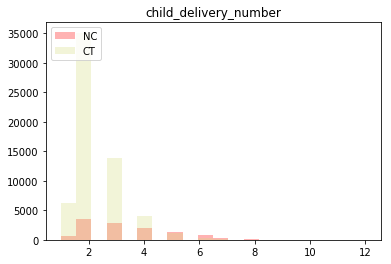

--------------------------------
binary traits -- big_baby
      case  control  missing
NC   743.0  15085.0   3176.0
AS     NaN      NaN   7612.0
CT  4325.0  77398.0  17511.0


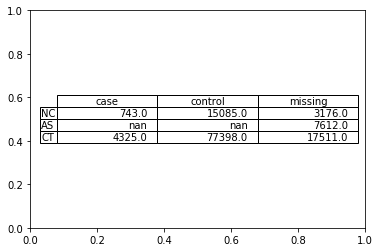

--------------------------------
binary traits -- small_baby
      case  control  missing
NC   178.0  15568.0   3258.0
AS     NaN      NaN   7612.0
CT  2602.0  78565.0  18067.0


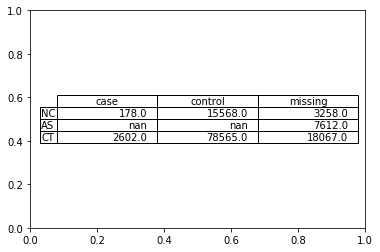

--------------------------------
quantitative traits -- child_present


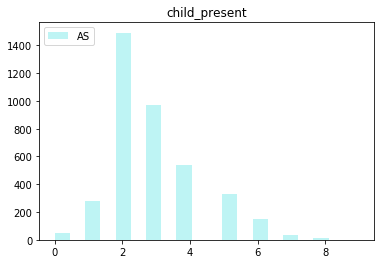

--------------------------------
quantitative traits -- child_dead


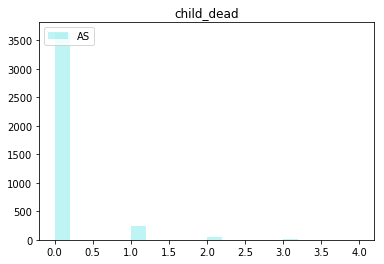

--------------------------------
quantitative traits -- hematocrit


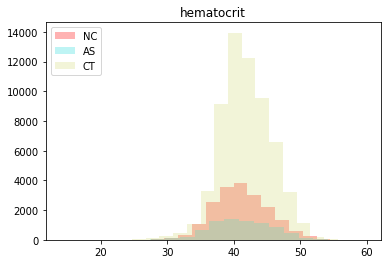

--------------------------------
quantitative traits -- hemoglobin


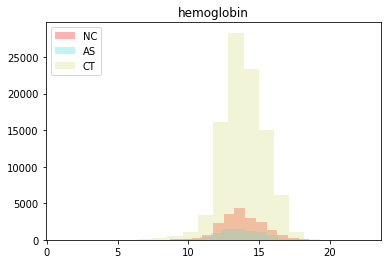

--------------------------------
quantitative traits -- platelet


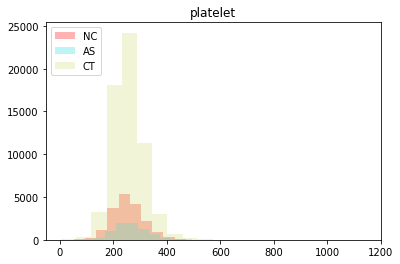

--------------------------------
quantitative traits -- rbc


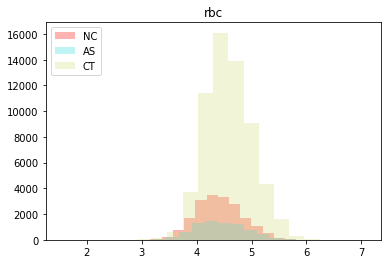

--------------------------------
quantitative traits -- wbc


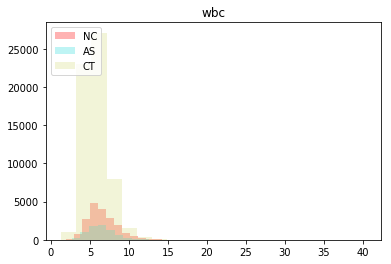

--------------------------------
quantitative traits -- mcv


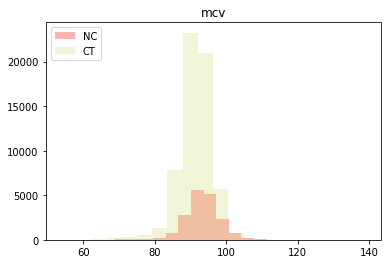

--------------------------------
quantitative traits -- mch


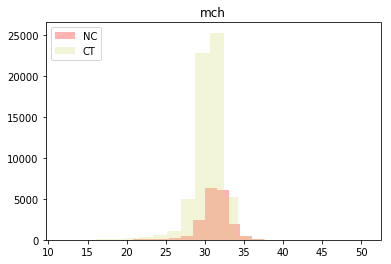

--------------------------------
quantitative traits -- mchc


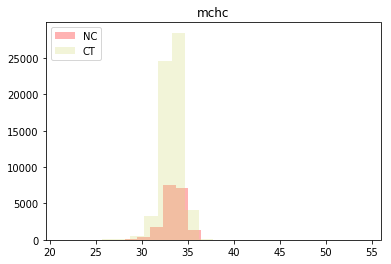

--------------------------------
quantitative traits -- total_bilirubin


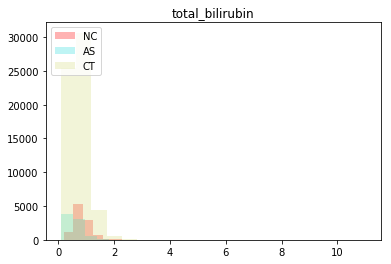

--------------------------------
quantitative traits -- bun


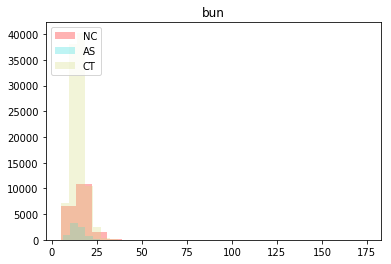

--------------------------------
quantitative traits -- creatinine


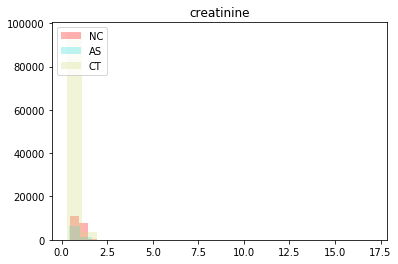

--------------------------------
quantitative traits -- blood_in_urine


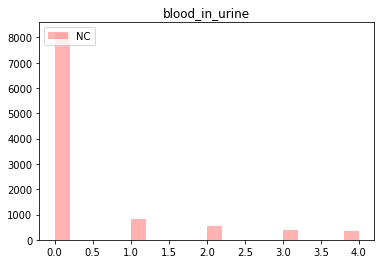

--------------------------------
quantitative traits -- glucose_in_urine


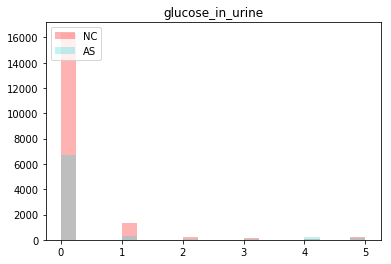

--------------------------------
quantitative traits -- alt


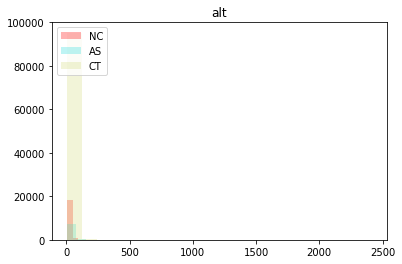

--------------------------------
quantitative traits -- ast


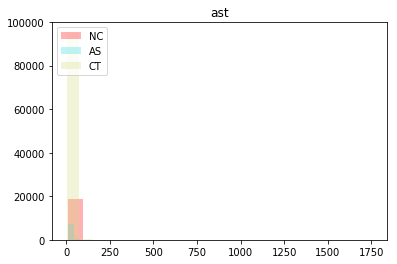

--------------------------------
quantitative traits -- gtp


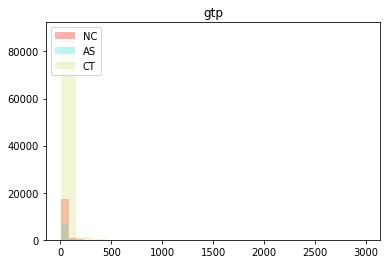

--------------------------------
quantitative traits -- total_cholesterol


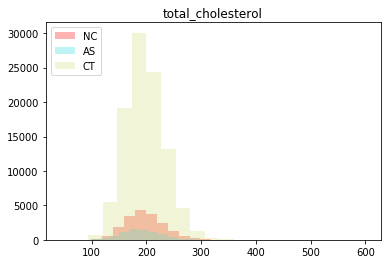

--------------------------------
quantitative traits -- hdl_cholesterol


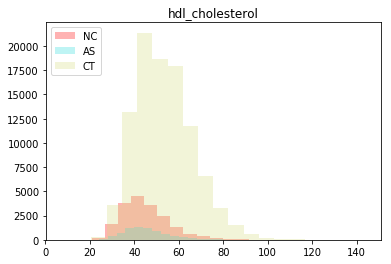

--------------------------------
quantitative traits -- hba1c


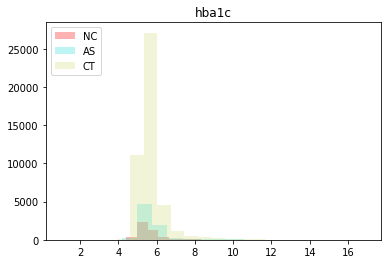

--------------------------------
quantitative traits -- freet4


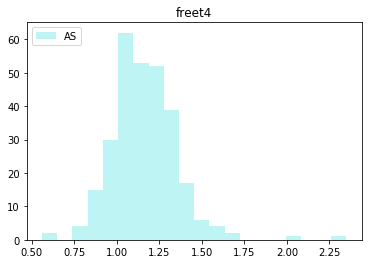

--------------------------------
quantitative traits -- tsh


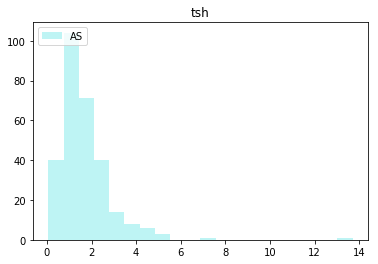

--------------------------------
quantitative traits -- triglyceride


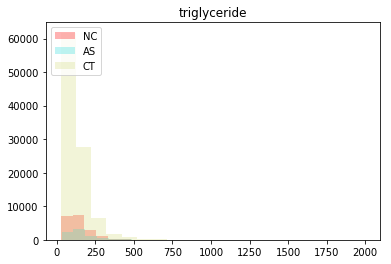

--------------------------------
quantitative traits -- albumin


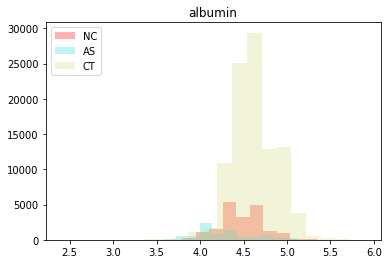

--------------------------------
quantitative traits -- hscrp


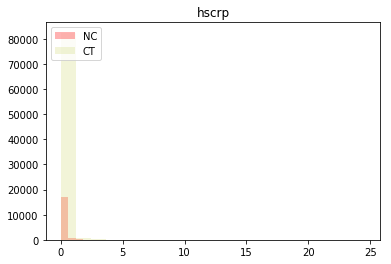

--------------------------------
quantitative traits -- protein_in_urine


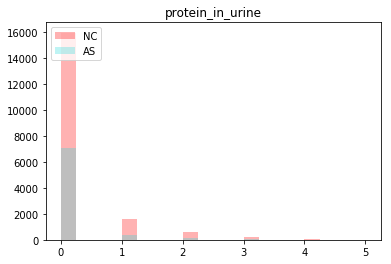

--------------------------------
binary traits -- heart_failure
    case  control  missing
NC  75.0  15670.0   3259.0
AS  16.0   5900.0   1696.0
CT   NaN      NaN  99234.0


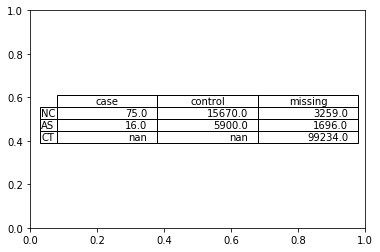

--------------------------------
binary traits -- peripheral_vascular_diseases
    case  control  missing
NC   NaN      NaN  19004.0
AS  24.0   5893.0   1695.0
CT   NaN      NaN  99234.0


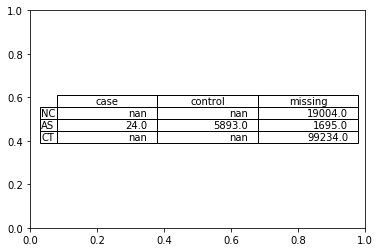

--------------------------------
binary traits -- cataract
      case  control  missing
NC   378.0  15498.0   3128.0
AS     NaN      NaN   7612.0
CT  3344.0  78698.0  17192.0


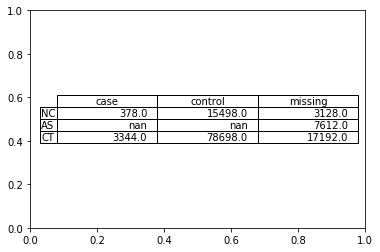

--------------------------------
binary traits -- glaucoma
     case  control  missing
NC   56.0  15676.0   3272.0
AS    NaN      NaN   7612.0
CT  574.0  80250.0  18410.0


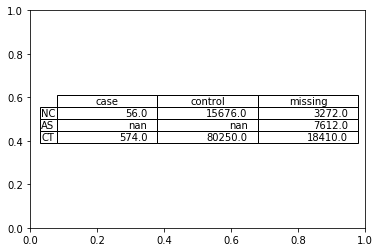

--------------------------------
binary traits -- renal_failure
     case  control  missing
NC    NaN      NaN  19004.0
AS    NaN      NaN   7612.0
CT  110.0  80561.0  18563.0


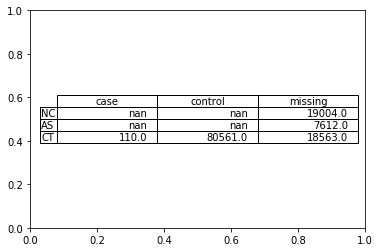

--------------------------------
quantitative traits -- renin


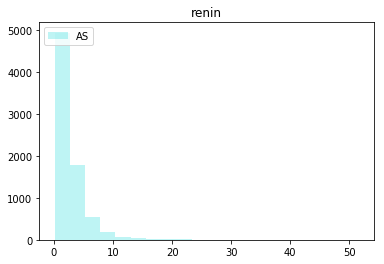

--------------------------------
binary traits -- fatty_liver
      case  control  missing
NC   726.0  15251.0   3027.0
AS     NaN      NaN   7612.0
CT  5483.0  76913.0  16838.0


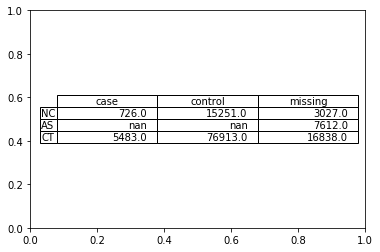

--------------------------------
binary traits -- copd
     case  control  missing
NC    NaN      NaN  19004.0
AS   53.0   5875.0   1684.0
CT  140.0  80532.0  18562.0


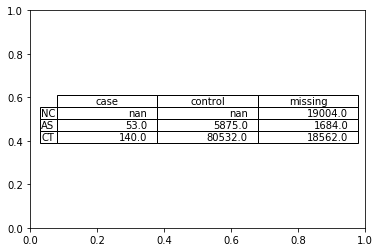

--------------------------------
binary traits -- tuberculosis
     case  control  missing
NC  404.0  15398.0   3202.0
AS    NaN      NaN   7612.0
CT    NaN      NaN  99234.0


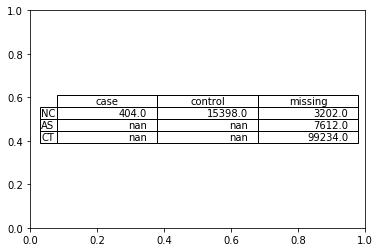

--------------------------------
binary traits -- benign_prostatic_hyperplasia
     case  control  missing
NC  168.0  15588.0   3248.0
AS    NaN      NaN   7612.0
CT    NaN      NaN  99234.0


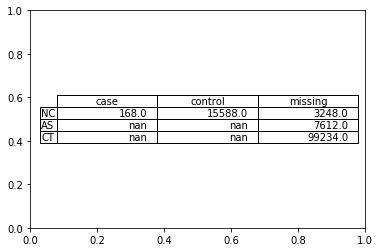

--------------------------------
binary traits -- gout
     case  control  missing
NC    NaN      NaN  19004.0
AS  454.0   5851.0   1307.0
CT  601.0  80181.0  18452.0


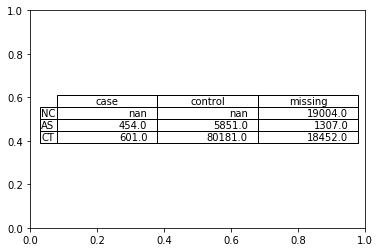

--------------------------------
binary traits -- fracture
       case  control  missing
NC    635.0  15180.0   3189.0
AS      NaN      NaN   7612.0
CT  10239.0  72683.0  16312.0


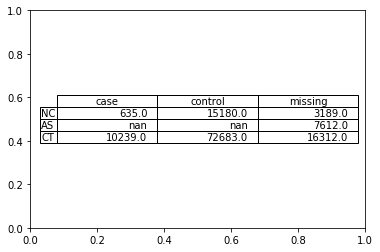

--------------------------------
binary traits -- cholelithiasis_cholecystitis
      case  control  missing
NC   283.0  15515.0   3206.0
AS     NaN      NaN   7612.0
CT  2705.0  78738.0  17791.0


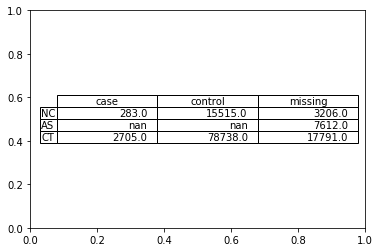

--------------------------------
binary traits -- periodontal_disease
      case  control  missing
NC     NaN      NaN  19004.0
AS     NaN      NaN   7612.0
CT  6100.0  76372.0  16762.0


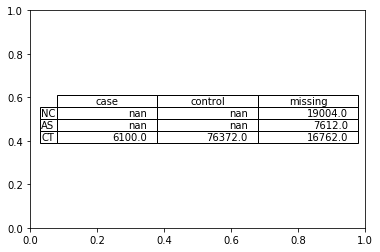

--------------------------------
binary traits -- insomnia
      case  control  missing
NC     NaN      NaN  19004.0
AS  1219.0   5101.0   1292.0
CT     NaN      NaN  99234.0


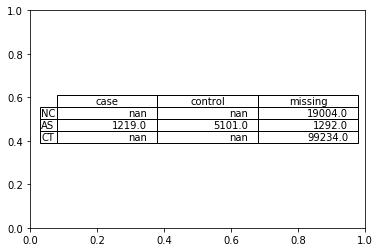

--------------------------------
quantitative traits -- sleep_duration


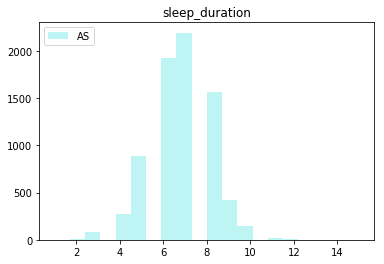

--------------------------------
binary traits -- neurosis
     case  control  missing
NC  112.0  15652.0   3240.0
AS    NaN      NaN   7612.0
CT    NaN      NaN  99234.0


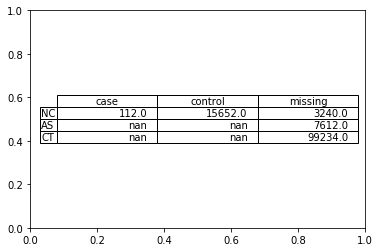

--------------------------------
binary traits -- chest_x_ray_00
      case  control  missing
NC     NaN      NaN  19004.0
AS  2328.0   4108.0   1176.0
CT     NaN      NaN  99234.0


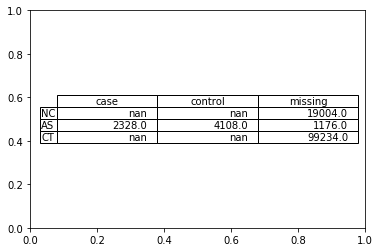

--------------------------------
binary traits -- chest_x_ray_01
     case  control  missing
NC    NaN      NaN  19004.0
AS  198.0   5749.0   1665.0
CT    NaN      NaN  99234.0


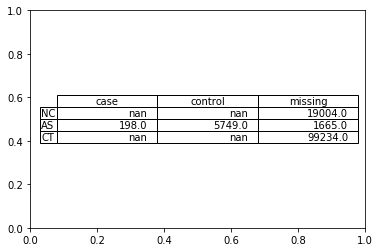

--------------------------------
binary traits -- chest_x_ray_02
     case  control  missing
NC    NaN      NaN  19004.0
AS  332.0   5635.0   1645.0
CT    NaN      NaN  99234.0


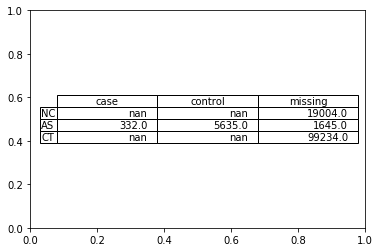

--------------------------------
binary traits -- chest_x_ray_03
     case  control  missing
NC    NaN      NaN  19004.0
AS  255.0   5748.0   1609.0
CT    NaN      NaN  99234.0


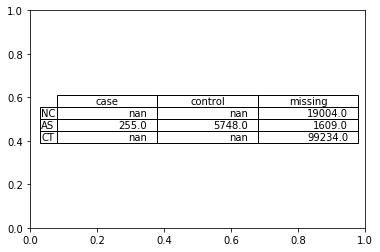

--------------------------------
binary traits -- chest_x_ray_04
     case  control  missing
NC    NaN      NaN  19004.0
AS  636.0   5372.0   1604.0
CT    NaN      NaN  99234.0


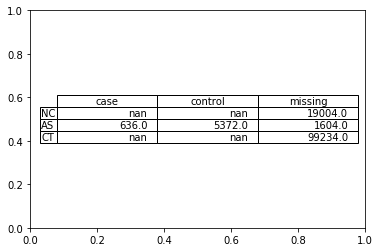

--------------------------------
binary traits -- chest_x_ray_05
     case  control  missing
NC    NaN      NaN  19004.0
AS  741.0   5328.0   1543.0
CT    NaN      NaN  99234.0


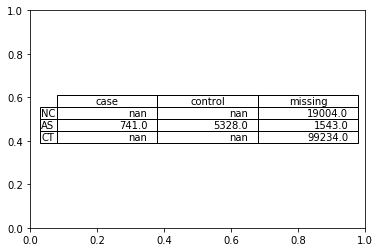

--------------------------------
binary traits -- chest_x_ray_06
    case  control  missing
NC   NaN      NaN  19004.0
AS  25.0   5891.0   1696.0
CT   NaN      NaN  99234.0


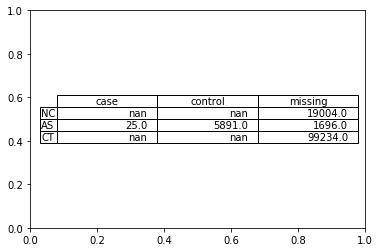

--------------------------------
binary traits -- chest_x_ray_07
    case  control  missing
NC   NaN      NaN  19004.0
AS  25.0   5888.0   1699.0
CT   NaN      NaN  99234.0


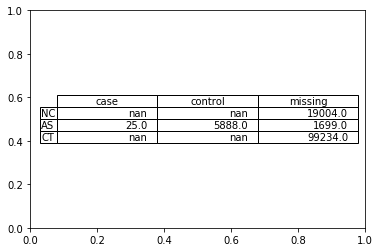

--------------------------------
binary traits -- chest_x_ray_08
     case  control  missing
NC    NaN      NaN  19004.0
AS  140.0   5808.0   1664.0
CT    NaN      NaN  99234.0


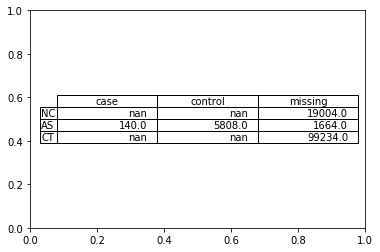

--------------------------------
binary traits -- chest_x_ray_09
    case  control  missing
NC   NaN      NaN  19004.0
AS  30.0   5887.0   1695.0
CT   NaN      NaN  99234.0


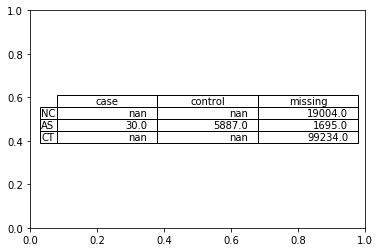

--------------------------------
binary traits -- chest_x_ray_10
    case  control  missing
NC   NaN      NaN  19004.0
AS  44.0   5876.0   1692.0
CT   NaN      NaN  99234.0


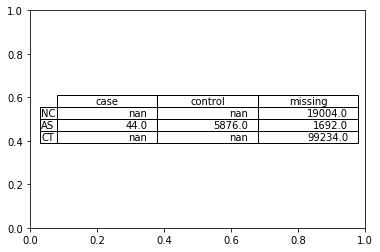

--------------------------------
binary traits -- chest_x_ray_11
    case  control  missing
NC   NaN      NaN  19004.0
AS  23.0   5890.0   1699.0
CT   NaN      NaN  99234.0


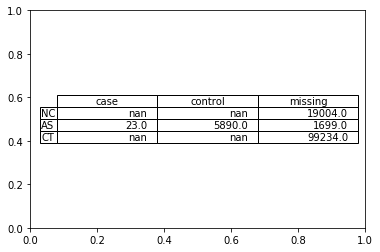

--------------------------------
binary traits -- chest_x_ray_12
     case  control  missing
NC    NaN      NaN  19004.0
AS  277.0   5698.0   1637.0
CT    NaN      NaN  99234.0


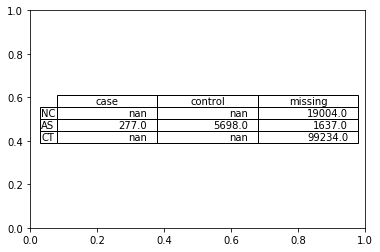

--------------------------------
binary traits -- chest_x_ray_13
    case  control  missing
NC   NaN      NaN  19004.0
AS   6.0   5902.0   1704.0
CT   NaN      NaN  99234.0


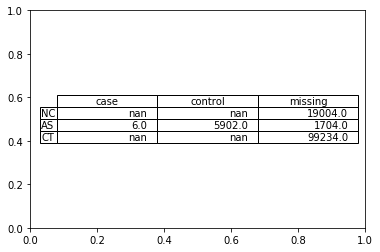

--------------------------------
binary traits -- chest_x_ray_14
    case  control  missing
NC   NaN      NaN  19004.0
AS   2.0   5904.0   1706.0
CT   NaN      NaN  99234.0


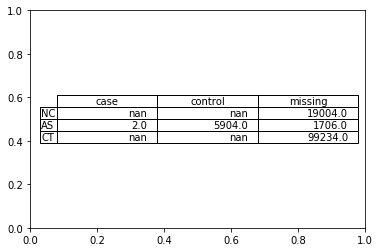

--------------------------------
binary traits -- chest_x_ray_15
    missing
NC    19004
AS     7612
CT    99234


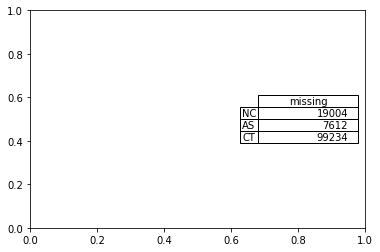

--------------------------------
binary traits -- chest_x_ray_16
    missing
NC    19004
AS     7612
CT    99234


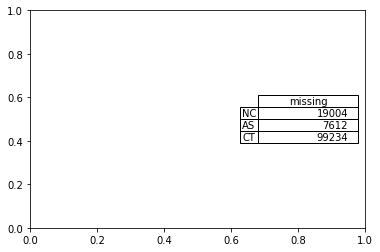

--------------------------------
binary traits -- chest_x_ray_17
    case  control  missing
NC   NaN      NaN  19004.0
AS   1.0   5906.0   1705.0
CT   NaN      NaN  99234.0


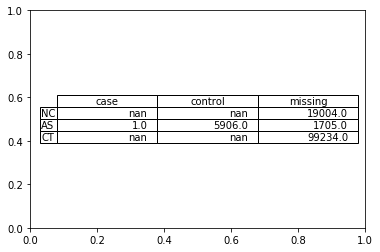

--------------------------------
binary traits -- chest_x_ray_18
    case  control  missing
NC   NaN      NaN  19004.0
AS   1.0   5905.0   1706.0
CT   NaN      NaN  99234.0


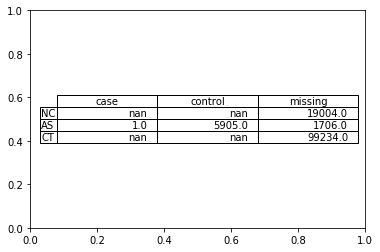

--------------------------------
binary traits -- chest_x_ray_19
    case  control  missing
NC   NaN      NaN  19004.0
AS  66.0   5854.0   1692.0
CT   NaN      NaN  99234.0


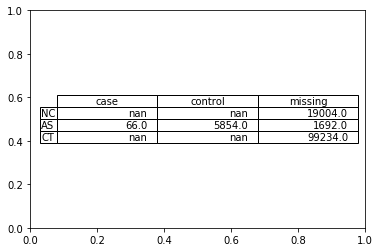

--------------------------------
binary traits -- chest_x_ray_20
    case  control  missing
NC   NaN      NaN  19004.0
AS   9.0   5901.0   1702.0
CT   NaN      NaN  99234.0


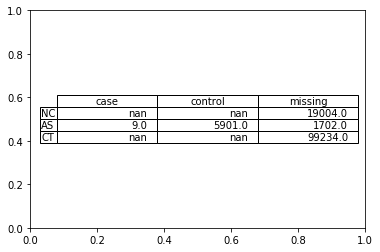

--------------------------------
binary traits -- chest_x_ray_21
     case  control  missing
NC    NaN      NaN  19004.0
AS  101.0   5827.0   1684.0
CT    NaN      NaN  99234.0


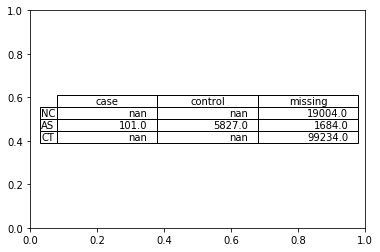

--------------------------------
binary traits -- chest_x_ray_22
    case  control  missing
NC   NaN      NaN  19004.0
AS   3.0   5904.0   1705.0
CT   NaN      NaN  99234.0


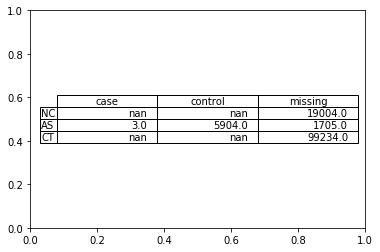

--------------------------------
binary traits -- chest_x_ray_23
    case  control  missing
NC   NaN      NaN  19004.0
AS  27.0   5882.0   1703.0
CT   NaN      NaN  99234.0


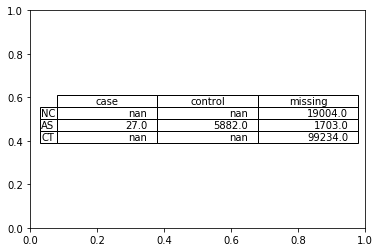

--------------------------------
binary traits -- chest_x_ray_24
    case  control  missing
NC   NaN      NaN  19004.0
AS   2.0   5904.0   1706.0
CT   NaN      NaN  99234.0


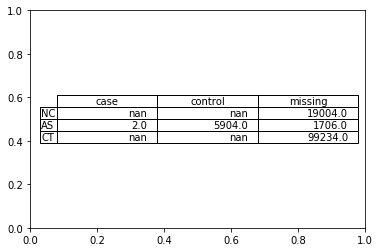

--------------------------------
binary traits -- chest_x_ray_25
    case  control  missing
NC   NaN      NaN  19004.0
AS  19.0   5891.0   1702.0
CT   NaN      NaN  99234.0


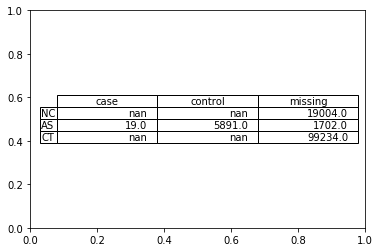

--------------------------------
binary traits -- chest_x_ray_26
    missing
NC    19004
AS     7612
CT    99234


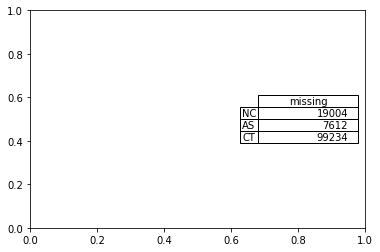

--------------------------------
binary traits -- chest_x_ray_27
    missing
NC    19004
AS     7612
CT    99234


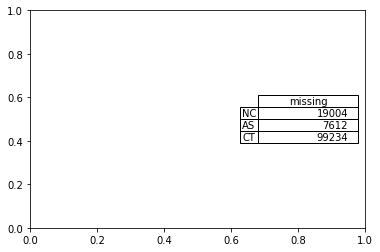

--------------------------------
binary traits -- chest_x_ray_28
    case  control  missing
NC   NaN      NaN  19004.0
AS   6.0   5900.0   1706.0
CT   NaN      NaN  99234.0


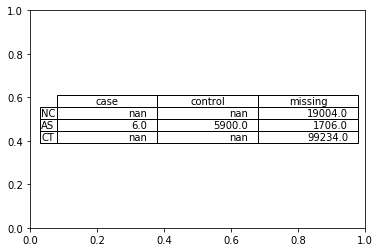

--------------------------------
binary traits -- chest_x_ray_29
    missing
NC    19004
AS     7612
CT    99234


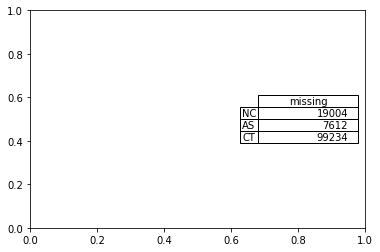

--------------------------------
binary traits -- chest_x_ray_30
    case  control  missing
NC   NaN      NaN  19004.0
AS   1.0   5905.0   1706.0
CT   NaN      NaN  99234.0


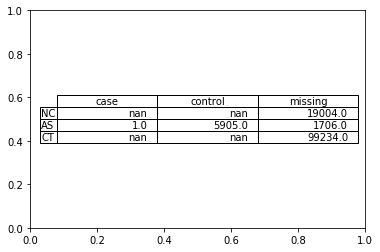

--------------------------------
binary traits -- chest_x_ray_31
    missing
NC    19004
AS     7612
CT    99234


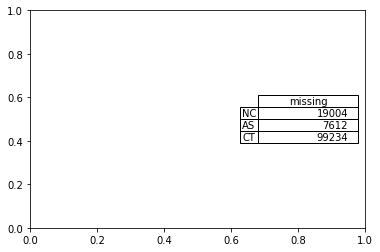

--------------------------------
binary traits -- chest_x_ray_32
    case  control  missing
NC   NaN      NaN  19004.0
AS   6.0   5902.0   1704.0
CT   NaN      NaN  99234.0


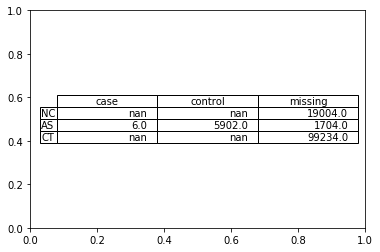

--------------------------------
binary traits -- chest_x_ray_33
    case  control  missing
NC   NaN      NaN  19004.0
AS  11.0   5898.0   1703.0
CT   NaN      NaN  99234.0


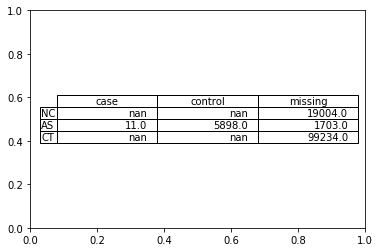

--------------------------------
binary traits -- chest_x_ray_34
    case  control  missing
NC   NaN      NaN  19004.0
AS  45.0   5876.0   1691.0
CT   NaN      NaN  99234.0


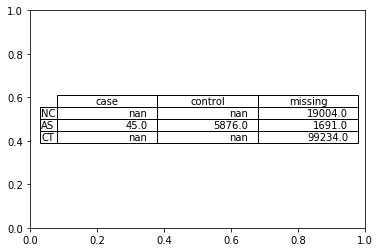

--------------------------------
quantitative traits -- grip_strength


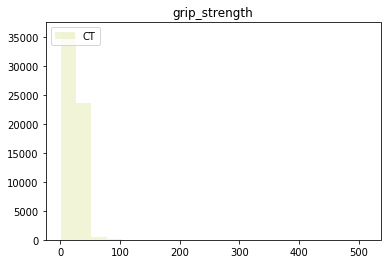

--------------------------------
quantitative traits -- ALP


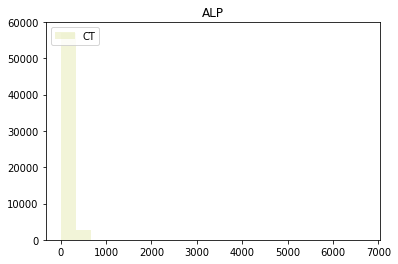

--------------------------------
quantitative traits -- FVC_predicted


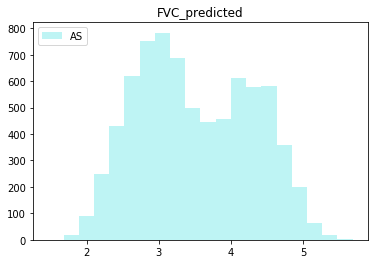

--------------------------------
quantitative traits -- FEV_predicted


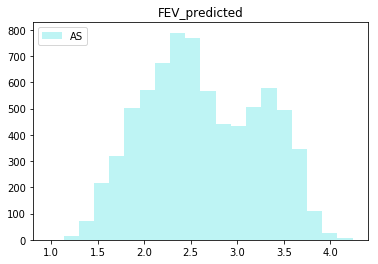

--------------------------------
quantitative traits -- FEV_over_FVC_predicted


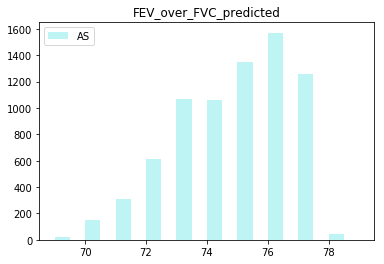

--------------------------------
quantitative traits -- MVV_predicted


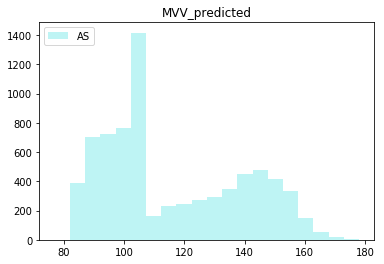

--------------------------------
quantitative traits -- bone_density_distal_sos


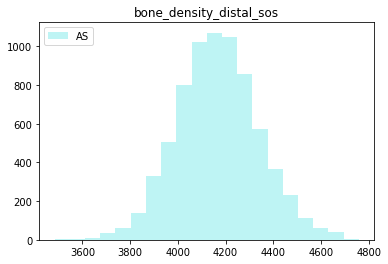

--------------------------------
quantitative traits -- bone_density_midshaft_sos


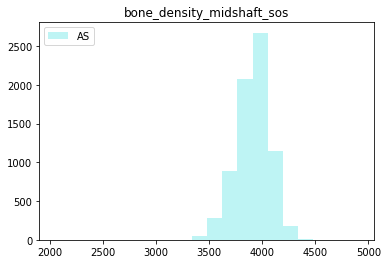

--------------------------------
quantitative traits -- protein_in_blood


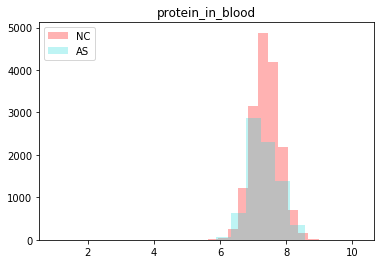

--------------------------------
quantitative traits -- glucose_in_blood


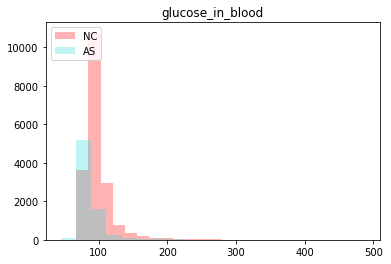

--------------------------------
quantitative traits -- cohort


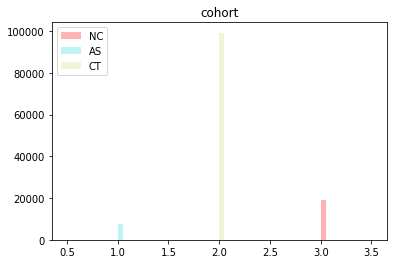

--------------------------------
quantitative traits -- bmi


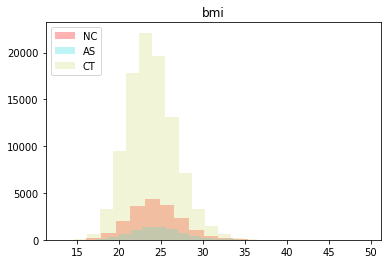

--------------------------------


In [44]:
for new_name,value in conversion_df.iteritems():
    value=value.copy()
    value_unique=value.unique()
    
    if (len(value_unique)==1) or len(value_unique)==2 and pd.isnull(value_unique).any() and (value_unique==2).any():
        print("binary traits","--",new_name)
        #value setting
        value[value!=2]=-9
        for cohort in conversion_df['cohort'].unique():
            cohort_bool=(conversion_df['cohort']==cohort)
            if (cohort_bool & (value==2)).any(): # if a questionnaire about this phenotype has been ever asked.
                value[cohort_bool & (value==-9) & control_filter]=1
        #summary
        phenotype_stat=pd.DataFrame([value[conversion_df['cohort']==cohort].value_counts().rename(cohort_to_name(cohort)) for cohort in conversion_df['cohort'].unique()])
        phenotype_stat=phenotype_stat.rename(columns={2: 'case', 1: 'control',-9:'missing'})
        phenotype_stat=phenotype_stat[phenotype_stat.columns.sort_values()]
        print(phenotype_stat)
        
        fig=plt.figure()
        plt.table(cellText=phenotype_stat.values,
                  colWidths = [0.3]*3,
                  rowLabels=phenotype_stat.index,
                  colLabels=phenotype_stat.columns,
                  loc='center right')
        plt.show()
        
        #print("case: {}".format((value==2).sum()))
        #print("control: {}".format((value==1).sum()))
        #print("missing: {}".format((value==-9).sum()))
    
    
    
    else:
        print("quantitative traits","--",new_name)
        #print(value_unique)
        value=value.fillna(-9)
        
        fig=plt.figure()
        plt.title(new_name)
        for cohort in conversion_df['cohort'].unique():
            cohort_bool=(conversion_df['cohort']==cohort)
            if (value[cohort_bool]!=-9).sum()==0:
                continue
            plt.hist(value[cohort_bool & (value!=-9)],bins=20,color=plt.cm.rainbow(cohort/3),label=cohort_to_name(cohort),alpha=0.3)
        plt.legend(loc='upper left')
        plt.show()
        
    value=value.map(try_float_to_int)
    phenotype_tosave=value.reset_index()
    phenotype_tosave=phenotype_tosave[[phenotype_tosave.columns[0],phenotype_tosave.columns[0],phenotype_tosave.columns[1]]]
    #phenotype_tosave.to_csv(pheno_file_path.format(new_name),sep=' ',index=None,header=None)
    #fig.savefig(pheno_sumstatsjpg_file_path.format(new_name))
        
    print('--------------------------------')

## (deprecated)Selecting individuals to be included in control group

In [89]:
conversion_df['arthritis'].unique(),conversion_df['diabetes'].unique(),conversion_df['thyroid_disease'].unique(),conversion_df['cervical_cancer'].unique()

(array([nan,  2.]),
 array([ 2., nan]),
 array([nan,  2.]),
 array([nan, 2.0], dtype=object))

In [37]:
print(len(conversion_df.index))
control_select=conversion_df.index[~(conversion_df['arthritis']==2)]
control_idx=conversion_df.index.intersection(control_select)
print(len(control_select),len(control_idx))
control_select=conversion_df.index[~(conversion_df['diabetes']==2)]
control_idx=control_idx.intersection(control_select)
print(len(control_select),len(control_idx))
control_select=conversion_df.index[~(conversion_df['thyroid_disease']==2)]
control_idx=control_idx.intersection(control_select)
print(len(control_select),len(control_idx))
control_select=conversion_df.index[~(conversion_df['cervical_cancer']==2)]
control_idx=control_idx.intersection(control_select)
print(len(control_select),len(control_idx))

125850
114492 114492
116938 106618
120706 102564
125429 102246


In [38]:
control_filter=(conversion_df['age']<0)
control_filter[control_idx]=True
control_filter.sum()

102246

In [40]:
(conversion_df['age']<0).sum()

0

# Run genotype-phenotype association

In [ ]:
for new_name,converson in conversion_dict.items():
    print(conversion_dict[new_name].reset_index().isnull().sum())
    phenotype_tosave=conversion_dict[new_name].reset_index().fillna(-9)
    phenotype_tosave=phenotype_tosave[[phenotype_tosave.columns[0],phenotype_tosave.columns[0],phenotype_tosave.columns[1]]]
    phenotype_tosave.to_csv(pheno_file_path.format(new_name),sep=' ',index=None,header=None)

In [56]:
new_name='ACC'
run_subprocess('plink --bfile {} --assoc --pheno {} --linear --out {}'.format(imputed_bfile_path,pheno_file_path.format(new_name),assoc_file_path.format(new_name)))

------RUN-----
plink --bfile data/genotype/HLA_IMPUTED_Result.KCHIP_HLA.MHC --assoc --pheno data/out_pheno/ACC.pheno --linear --out data/out_assoc/ACC
------ERROR-----
Error: --linear without --all-pheno requires a scalar phenotype.

------OUTPUT-----
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/out_assoc/ACC.log.
Options in effect:
  --assoc
  --bfile data/genotype/HLA_IMPUTED_Result.KCHIP_HLA.MHC
  --linear
  --out data/out_assoc/ACC
  --pheno data/out_pheno/ACC.pheno

305729 MB RAM detected; reserving 152864 MB for main workspace.
6354 variants loaded from .bim file.
125872 people (45726 males, 80146 females) loaded from .fam.
7531 phenotype values present after --pheno.



(b'PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/\n(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3\nLogging to data/out_assoc/ACC.log.\nOptions in effect:\n  --assoc\n  --bfile data/genotype/HLA_IMPUTED_Result.KCHIP_HLA.MHC\n  --linear\n  --out data/out_assoc/ACC\n  --pheno data/out_pheno/ACC.pheno\n\n305729 MB RAM detected; reserving 152864 MB for main workspace.\n6354 variants loaded from .bim file.\n125872 people (45726 males, 80146 females) loaded from .fam.\n7531 phenotype values present after --pheno.\n',
 b'Error: --linear without --all-pheno requires a scalar phenotype.\n')

In [ ]:
for new_name,converson in conversion_dict.items():
    run_subprocess('plink --bfile {} --assoc --pheno {} --linear --out {}'.format(imputed_bfile_path,pheno_file_path.format(new_name),assoc_file_path.format(new_name)))

In [ ]:
for new_name,converson in conversion_dict.items():
    run_subprocess('plink --bfile {} --assoc --pheno {} --out {}'.format(imputed_bfile_path,pheno_file_path.format(new_name),assoc_file_path.format(new_name)))

# Histogram

In [72]:
def parse_plink_assoc(file_name):
    with open(file_name,'r') as f:
        lines=f.readlines()
        #lines=[line.strip().split(' ') for line in lines]
        header=re.split('\s+',lines[0].strip())
        lines=[re.split('\s+',line.strip()) for line in lines[1:]]
    #return pd.DataFrame(lines,columns=header).replace('NA',np.nan).astype({'BP':int,'A1':str,'A2':str,'F_A':float,'F_U':float,'P':float,'OR':float})
    print(header)
    try:
        return pd.DataFrame(lines,columns=header).replace('NA',np.nan).astype({'CHR':int,'SNP':str,'BP':int,'A1':str,'NMISS':int,'OR':float,'STAT':float,'P':float})
    except:
        return pd.DataFrame(lines,columns=header).replace('NA',np.nan).astype({'BP':int,'A1':str,'A2':str,'F_A':float,'F_U':float,'P':float,'OR':float})
    #.astype({'BP':int,'A1':str,'A2':str,'F_A':float,'F_U':float,'P':float,'OR':float})

In [73]:
import re

In [76]:
a=parse_plink_assoc('data/out_assoc/asthma/step_01.plink.assoc.logistic').sort_values('P')
a

['CHR', 'SNP', 'BP', 'A1', 'TEST', 'NMISS', 'OR', 'STAT', 'P']


,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
40675,6,6:32408907_G/A,32408907,A,ADD,125673,0.8511,-4.800,0.000002
40792,6,6:32416058_CT/C,32416058,CT,ADD,125673,1.1610,4.762,0.000002
40726,6,6:32412388_T/G,32412388,T,ADD,125673,0.8661,-4.508,0.000007
40684,6,6:32409305_A/G,32409305,A,ADD,125673,0.8680,-4.464,0.000008
40692,6,6:32409781_C/T,32409781,C,ADD,125673,0.8680,-4.463,0.000008
...,...,...,...,...,...,...,...,...,...
67392,6,SNPS_DPB1_355_33152151_intron1,33152151,.,ADD,124514,NaN,NaN,NaN
67407,6,SNPS_DPB1_1079_33152875_intron1,33152875,T,ADD,124514,NaN,NaN,NaN
67444,6,SNPS_DPB1_2301_33154097_intron1,33154097,T,ADD,124514,NaN,NaN,NaN
67479,6,SNPS_DPB1_4371_33156167_intron1,33156167,T,ADD,124514,NaN,NaN,NaN


In [77]:
a[a.SNP=='HLA_DQA1*05:09']

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
58828,6,HLA_DQA1*05:09,32713161,p,ADD,125850,NaN,NaN,NaN


In [75]:
parse_plink_assoc('data/out_assoc/asthma/step_01.plink.assoc').sort_values('P')

['CHR', 'SNP', 'BP', 'A1', 'F_A', 'F_U', 'A2', 'CHISQ', 'P', 'OR']
ss


,CHR,SNP,BP,A1,F_A,F_U,A2,CHISQ,P,OR
58828,6,HLA_DQA1*05:09,32713161,p,0.000236,0.000000,a,58.42,2.118000e-14,NaN
58840,6,SNPS_DQA1_70_32713283_exon1,32713283,A,0.000239,0.000000,G,58.32,2.223000e-14,NaN
40675,6,6:32408907_G/A,32408907,A,0.307600,0.342900,G,23.11,1.534000e-06,0.8511
33656,6,HLA_B*35:08,31429628,p,0.000944,0.000113,a,22.63,1.962000e-06,8.3530
40792,6,6:32416058_CT/C,32416058,CT,0.516800,0.480200,C,22.32,2.304000e-06,1.1580
...,...,...,...,...,...,...,...,...,...,...
36600,6,6:31919956_T/C,31919956,C,0.082270,0.082270,T,1.104e-08,9.999000e-01,1.0000
71498,6,6:33974423_T/A,33974423,A,0.286800,0.286800,T,2.761e-08,9.999000e-01,1.0000
26412,6,6:31237342_G/T,31237342,T,0.273800,0.273800,G,1.312e-08,9.999000e-01,1.0000
36615,6,6:31924880_G/A,31924880,A,0.082270,0.082270,G,1.104e-08,9.999000e-01,1.0000
